In [12]:
# For training model
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
# For utilities
import numpy as np
import networkx as nx
import math
import json
import pickle
import time
import ast
import matplotlib.pyplot as plt
from einops import rearrange

In [13]:
# Load proxy score data from json file
file_path = r'/home/ansonhon/mase_project/machop/naslib/data/zc_nasbenchnlp8901.json'
with open(file_path, 'r') as file:
    data = json.load(file)

In [14]:
# load model actual accuracy from pickle file
file_path = r'/home/ansonhon/mase_project/machop/naslib/data/nb_nlp.pickle'
# Open the file in read mode and load
with open(file_path, 'rb') as file:
    targets = pickle.load(file)

In [15]:
data_key_list = list(data.keys())
targets_key_list = list(targets.keys())

In [16]:
### Write data into two arrays
val_loss_list = []
score_list = []
compact_list = []
proxy_name_list = ['grasp', 'l2_norm', 'nwot', 'params', 'flops']
for key in data_key_list:
    key_tuple = ast.literal_eval(key)
    if key_tuple in targets_key_list:
        # Record final validation loss into list
        val_loss = targets[key_tuple]['val_losses'][-1]
        val_loss_list.append(val_loss)

        # Record small proxy score into list
        mini_list = []
        for proxy_name in proxy_name_list:
            mini_list.append(data[key][proxy_name])
        score_list.append([mini_list])

        # Record compact/hash into list
        compact_list.append(key_tuple)

print(len(score_list))

355


In [18]:
class NeuralModel(nn.Module):
    def __init__(self, input_size):
        super(NeuralModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(64, 128)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [19]:
data_numpy = np.array(score_list)
data_numpy = np.where(np.isinf(data_numpy) & (data_numpy < 0), 0, data_numpy)
data_numpy = rearrange(data_numpy, 'n 1 d -> n d')
# z-normalize data
mean = np.mean(data_numpy, axis=0)
std_dev = np.std(data_numpy, axis=0)                                 
z_normalized_data = (data_numpy - mean) / (std_dev)
z_normalized_data = np.where(np.isnan(z_normalized_data), 0, z_normalized_data)
z_normalized_data[:,4] = 1

target_numpy = np.array(val_loss_list)
data_tensor = torch.tensor(z_normalized_data, dtype=torch.float32)
target_tensor = torch.tensor(target_numpy, dtype=torch.float32)

/tmp/ipykernel_1397/2713344997.py:7: RuntimeWarning: invalid value encountered in divide
  z_normalized_data = (data_numpy - mean) / (std_dev)


In [20]:
# Split data into train and test sets
test_size = int(0.1 * len(data_tensor))  # 10% of the data for testing
indices = np.arange(len(data_tensor))
np.random.shuffle(indices)
train_indices, test_indices = indices[test_size:], indices[:test_size]

data_train, data_test = data_tensor[train_indices], data_tensor[test_indices]
target_train, target_test = target_tensor[train_indices], target_tensor[test_indices]

# Define hyperparameters
input_size = 5  # Dimension of the data
initial_learning_rate = 0.1
batch_size = 8
num_epochs = 50
gamma = 0.9

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(data_train, target_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(data_test, target_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = NeuralModel(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
scheduler = ExponentialLR(optimizer, gamma=gamma)

# Training loop
test_losses = []
final_output = []
final_targets = []
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        # print("outputs: ", outputs)
        # print("targets: ", targets)
        # Compute loss
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    # Evaluation on test set
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            if epoch == 99:
                final_output.append(outputs)
                final_targets.append(targets)


        test_losses.append(test_loss/len(test_loader))

print(f'Test Loss: {test_loss / len(test_loader):.4f}')

Epoch [1/50], Train Loss: 8.8767
Epoch [2/50], Train Loss: 3.4976
Epoch [3/50], Train Loss: 13.1082
Epoch [4/50], Train Loss: 16.2431
Epoch [5/50], Train Loss: 16.6447
Epoch [6/50], Train Loss: 11.7721
Epoch [7/50], Train Loss: 11.0280
Epoch [8/50], Train Loss: 8.5229
Epoch [9/50], Train Loss: 5.0902
Epoch [10/50], Train Loss: 4.7980
Epoch [11/50], Train Loss: 6.7445
Epoch [12/50], Train Loss: 2.0092
Epoch [13/50], Train Loss: 3.6189
Epoch [14/50], Train Loss: 4.7117
Epoch [15/50], Train Loss: 3.0479
Epoch [16/50], Train Loss: 2.5107
Epoch [17/50], Train Loss: 2.4664
Epoch [18/50], Train Loss: 2.3417
Epoch [19/50], Train Loss: 1.5737
Epoch [20/50], Train Loss: 0.8899
Epoch [21/50], Train Loss: 0.8903
Epoch [22/50], Train Loss: 1.3932
Epoch [23/50], Train Loss: 0.7084
Epoch [24/50], Train Loss: 1.3234
Epoch [25/50], Train Loss: 3.0664
Epoch [26/50], Train Loss: 1.4384
Epoch [27/50], Train Loss: 142.4664
Epoch [28/50], Train Loss: 1.5493
Epoch [29/50], Train Loss: 1.7411
Epoch [30/50], T

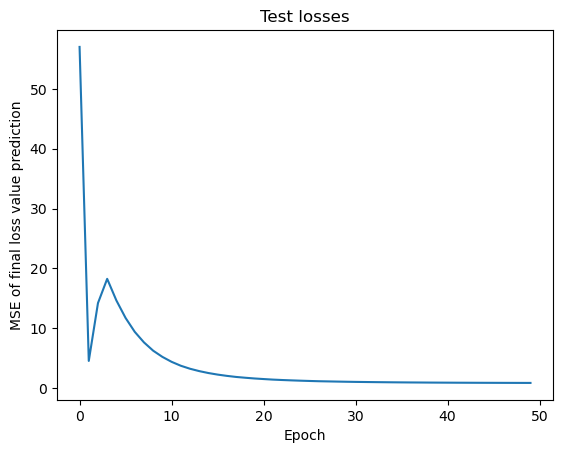

In [21]:
plt.plot(test_losses)
plt.title('Test losses')
plt.xlabel('Epoch')
plt.ylabel('MSE of final loss value prediction')
plt.show()

In [22]:
model.eval()
inputs_list = []
predictions = []
targets_list = []
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs_list.append(np.array(inputs[0][0]))
        targets_list.append(targets)
        outputs = model(inputs)
        predictions.append(outputs)
        
    

In [23]:
model.eval()
inputs_list = []
predictions = []
with torch.no_grad():
    for inputs, target in test_loader:
        inputs_list.append(inputs)
        outputs = model(inputs)
        predictions.append(outputs)

In [24]:
# corr_predictions_np = np.array(predictions)
concat_inputs = torch.cat(inputs_list, dim = 0)
inputs_np = concat_inputs.numpy()

targets_np = np.array(target_test)

concat_predictions = torch.cat(predictions, dim = 0)
predictions_np = concat_predictions.numpy()

In [25]:
predictions_np = rearrange(predictions_np, 'a 1 -> a')

In [26]:
grasp = inputs_np[:,0]
l2_norm = inputs_np[:,1]
nwot = inputs_np[:,2]
params = inputs_np[:,3]
flops = inputs_np[:,4]

corr_to_plot = np.stack((grasp, l2_norm, params,  predictions_np, targets_np), axis = 1)

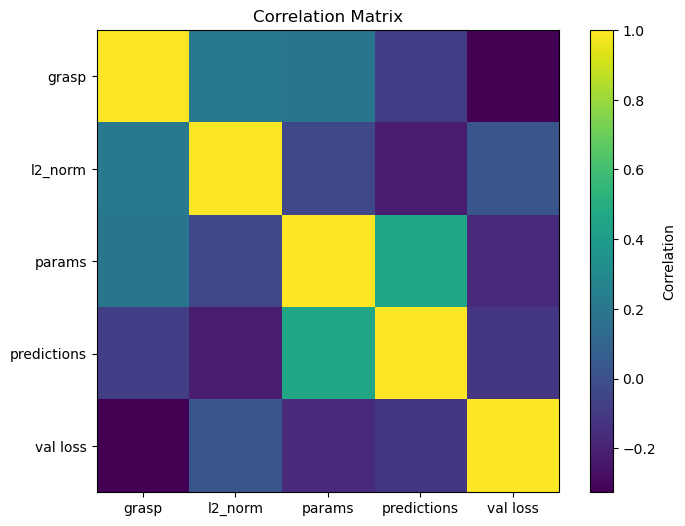

In [27]:
correlation_matrix = np.corrcoef(corr_to_plot, rowvar=False)
# Plot correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.xticks(np.arange(5), ['grasp', 'l2_norm',  'params',  'predictions', 'val loss' ])
plt.yticks(np.arange(5), ['grasp', 'l2_norm',  'params',  'predictions', 'val loss' ])
plt.show()